In [1]:
import sys
import os

# Add the build directory to Python path
build_dir = os.path.abspath('/Users/kisel/uni/apal/Algorithm-Selector/Implementation/lib')
sys.path.insert(0, build_dir)

# Add the data directory to Python path
data_dir = os.path.abspath('/Users/kisel/uni/apal/Algorithm-Selector/Implementation/data')
sys.path.insert(0, data_dir)

import pandas as pd
import numpy as np
from tqdm import tqdm

import sorters
import probes
import time

import list_generators as lg
import runtime_features as rf
import create_features_dataset as cfd

In [2]:
data = pd.read_feather("/Users/kisel/uni/apal/Algorithm-Selector/Implementation/data/data_and_features.feather")
data = data.tail(30000)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 26000 to 55999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   list_type  30000 non-null  object
 1   data       30000 non-null  object
 2   features   30000 non-null  object
 3   best_sort  30000 non-null  object
dtypes: object(4)
memory usage: 937.6+ KB


In [3]:
data['best_sort'].value_counts()

best_sort
std_sort          13024
insertion_sort     6988
spin_sort          6147
quick_sort         2609
tim_sort           1009
merge_sort          223
Name: count, dtype: int64

In [4]:
feat_rows = []
for row in data['features']:
    feat_rows.append(row)

df = pd.DataFrame(feat_rows)
print(df)

       avg_dup_distinct  avg_dup_pos  categorical_kurtosis  categorical_skew  \
0                   0.0          0.0                   0.0               0.0   
1                   0.0          0.0                   0.0               0.0   
2                   0.0          0.0                   0.0               0.0   
3                   0.0          0.0                   0.0               0.0   
4                   0.0          0.0                   0.0               0.0   
...                 ...          ...                   ...               ...   
29995               0.0          0.0                   0.0               0.0   
29996               0.0          0.0                   0.0               0.0   
29997               0.0          0.0                   0.0               0.0   
29998               0.0          0.0                   0.0               0.0   
29999               0.0          0.0                   0.0               0.0   

        dis    entropy  mono      range

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier

# 1. Build X correctly
X = pd.DataFrame(data['features'].tolist()).fillna(0)

# 2. Inspect target balance
print(data['best_sort'].value_counts())

# 3. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, data['best_sort'], test_size=0.2, random_state=42
)

model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.02,
    random_state=42,
    class_weight='balanced'
)

# 5. Fit + Evaluate
model.fit(X_train, y_train)
print("Accuracy:", accuracy_score(y_test, model.predict(X_test)))

best_sort
std_sort          13024
insertion_sort     6988
spin_sort          6147
quick_sort         2609
tim_sort           1009
merge_sort          223
Name: count, dtype: int64
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2000
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 10
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Accuracy: 0.8735


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Model with class_weight balanced
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    class_weight='balanced'  # Adjusts for class imbalance
)

# Train the model
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.8911666666666667
                precision    recall  f1-score   support

insertion_sort       0.99      1.00      1.00      1396
    merge_sort       0.05      0.02      0.03        48
    quick_sort       0.73      0.68      0.70       471
     spin_sort       0.77      0.91      0.84      1269
      std_sort       0.93      0.87      0.90      2612
      tim_sort       1.00      1.00      1.00       204

      accuracy                           0.89      6000
     macro avg       0.75      0.75      0.74      6000
  weighted avg       0.89      0.89      0.89      6000



In [7]:
def find_best_sorter(arr):
    best_name, best_time = None, float("inf")
    for sorter in sorters.list_sorters():
        time = sorters.benchmark_sorter(sorter, arr)
        if time < best_time:
            best_time, best_name = time, sorter

    return best_name

In [20]:
import numpy as np
import pandas as pd
import time

# 1. Generate test lists
lsts = [np.random.randint(0, 10000, size=1000).tolist() for _ in range(20)]

# 2. Extract features
feature_dicts = [rf.extract_features(lst) for lst in lsts]
X_batch = pd.DataFrame(feature_dicts).fillna(0)
X_batch = X_batch[X_train.columns]

# 3. Predict using trained model
start_model = time.time()
model_preds = rf_model.predict(X_batch)


# 4. Benchmark actual best sorters
start_true = time.time()
true_preds = [find_best_sorter(lst) for lst in lsts]
true_time = time.time() - start_true

# 5. Display results
print(f"\nModel prediction time: {model_time:.2f}s")
print(f"Benchmark (true best) time: {true_time:.2f}s\n")

print(f"{'Index':<6} {'Model':<20} {'Best (Measured)':<20} {'Match?'}")
print("-" * 60)
for i, (m, t) in enumerate(zip(model_preds, true_preds)):
    print(f"{i:<6} {m:<20} {t:<20} {'✅' if m == t else '❌'}")

# 6. Accuracy
matches = sum(m == t for m, t in zip(model_preds, true_preds))
print(f"\nMatched {matches} out of {len(lsts)} ({matches / len(lsts) * 100:.1f}% accuracy)")



Model prediction time: 0.00s
Benchmark (true best) time: 0.01s

Index  Model                Best (Measured)      Match?
------------------------------------------------------------
0      spin_sort            std_sort             ❌
1      spin_sort            spin_sort            ✅
2      quick_sort           spin_sort            ❌
3      spin_sort            spin_sort            ✅
4      spin_sort            spin_sort            ✅
5      spin_sort            spin_sort            ✅
6      std_sort             spin_sort            ❌
7      std_sort             spin_sort            ❌
8      spin_sort            spin_sort            ✅
9      std_sort             std_sort             ✅
10     std_sort             std_sort             ✅
11     quick_sort           merge_sort           ❌
12     std_sort             std_sort             ✅
13     spin_sort            spin_sort            ✅
14     spin_sort            quick_sort           ❌
15     spin_sort            std_sort             ❌
16

In [21]:
importances = rf_model.feature_importances_
features = X_train.columns

# Pair and sort
importance_list = sorted(zip(features, importances), key=lambda x: x[1], reverse=True)

print("\nFeature Importances:")
for feat, imp in importance_list:
    print(f"{feat:<25} {imp:.4f}")



Feature Importances:
mono                      0.2444
runs                      0.2300
range                     0.1668
dis                       0.1461
entropy                   0.0605
avg_dup_distinct          0.0360
avg_dup_pos               0.0302
categorical_kurtosis      0.0296
categorical_skew          0.0288
size                      0.0278


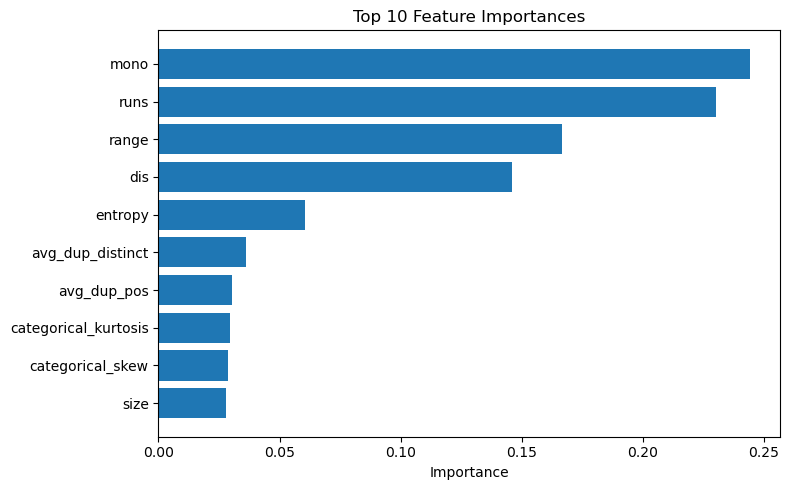

In [22]:
import matplotlib.pyplot as plt

# Plot top N features
top_n = 10
top_feats = importance_list[:top_n]
names, scores = zip(*top_feats)

plt.figure(figsize=(8, 5))
plt.barh(names[::-1], scores[::-1])
plt.xlabel("Importance")
plt.title(f"Top {top_n} Feature Importances")
plt.tight_layout()
plt.show()
